In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [4]:
# Correct the path to the dataset
gameweek_file_path = '/content/drive/My Drive/CPSC-171/Final Proj/fpl_combined_gameweek_data.csv'

# Load the dataset
df_gameweeks = pd.read_csv(gameweek_file_path)

# Preview the dataset
print("Dataset loaded successfully.")
print(f"Number of rows: {df_gameweeks.shape[0]}")
print(f"Number of columns: {df_gameweeks.shape[1]}")


Dataset loaded successfully.
Number of rows: 115969
Number of columns: 30


In [5]:
column_names = df_gameweeks.columns
column_names

Index(['gameweek', 'total_points', 'minutes', 'goals_scored', 'assists',
       'clean_sheets', 'saves', 'goals_conceded', 'own_goals',
       'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards',
       'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index',
       'value', 'was_home', 'opponent_team', 'season', 'bps_last_gameweek',
       'missing_bps_last_gameweek', 'team', 'position', 'weighted_goals',
       'weighted_clean_sheets', 'name'],
      dtype='object')

In [6]:
# Load the dataset
df = df_gameweeks.copy()

# Preview the dataset
print("Dataset preview:")
display(df.head())


Dataset preview:


,gameweek,total_points,minutes,goals_scored,assists,clean_sheets,saves,goals_conceded,own_goals,penalties_saved,...,was_home,opponent_team,season,bps_last_gameweek,missing_bps_last_gameweek,team,position,weighted_goals,weighted_clean_sheets,name
0,1,1,45,0,0,0,0,2,0,0,...,1,5,2020-21,0.0,1,Brighton,Forward,0,0,Aaron Connolly
1,2,8,89,1,0,1,0,0,0,0,...,0,14,2020-21,-3.0,0,Brighton,Forward,4,0,Aaron Connolly
2,3,2,73,0,0,0,0,2,0,0,...,1,13,2020-21,27.0,0,Brighton,Forward,0,0,Aaron Connolly
3,4,2,65,0,0,0,0,3,0,0,...,0,7,2020-21,2.0,0,Brighton,Forward,0,0,Aaron Connolly
4,5,4,12,0,1,0,0,0,0,0,...,0,6,2020-21,7.0,0,Brighton,Forward,0,0,Aaron Connolly


In [7]:
# Get data types and missing values
print("Data Types and Missing Values:")
display(df.info())

# Check for missing values
print("Missing Values:")
# display(df.isnull().sum())


Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115969 entries, 0 to 115968
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   gameweek                   115969 non-null  int64  
 1   total_points               115969 non-null  int64  
 2   minutes                    115969 non-null  int64  
 3   goals_scored               115969 non-null  int64  
 4   assists                    115969 non-null  int64  
 5   clean_sheets               115969 non-null  int64  
 6   saves                      115969 non-null  int64  
 7   goals_conceded             115969 non-null  int64  
 8   own_goals                  115969 non-null  int64  
 9   penalties_saved            115969 non-null  int64  
 10  penalties_missed           115969 non-null  int64  
 11  yellow_cards               115969 non-null  int64  
 12  red_cards                  115969 non-null  int64  
 13

None

Missing Values:


In [8]:
# Sort the data by 'name', 'season', and 'gameweek'
df = df.sort_values(by=['name', 'season', 'gameweek'])

# Define position-specific weights
position_weights = {
    "Goalkeeper": {"goal_weight": 10, "clean_sheet_weight": 4},
    "Defender": {"goal_weight": 6, "clean_sheet_weight": 4},
    "Midfielder": {"goal_weight": 5, "clean_sheet_weight": 1},
    "Forward": {"goal_weight": 4, "clean_sheet_weight": 0},
}

# One-hot encode 'position' using pd.get_dummies
df = pd.get_dummies(df, columns=['position'], prefix='position')

# Define positional feature relevance
position_feature_map = {
    'Goalkeeper': ['saves', 'penalties_saved', 'clean_sheets', 'goals_conceded', 'bonus', 'value', 'minutes'],
    'Defender': ['clean_sheets', 'goals_scored', 'assists', 'yellow_cards', 'red_cards', 'value', 'minutes'],
    'Midfielder': ['goals_scored', 'assists', 'creativity', 'influence', 'ict_index', 'value', 'minutes', 'yellow_cards'],
    'Forward': ['goals_scored', 'assists', 'threat', 'value', 'minutes', 'influence', 'creativity', 'yellow_cards', 'ict_index']
}

# Static columns (no lagging required)
static_columns = [
    'bps_last_gameweek', 'missing_bps_last_gameweek', 'was_home',
    'opponent_team', 'season', 'team', 'name'
]

# Initialize dictionary to hold lagged data
lagged_data = {}

# Create lagged features for each position-specific feature
for position, features in position_feature_map.items():
    # Check if position column exists
    position_col = f'position_{position}'
    if position_col in df.columns:
        # Mask to identify players of the current position
        position_mask = df[position_col] == 1

        for feature in features:
            for lag in range(1, 4):  # Lag of 1, 2, 3
                lag_col = f'{feature}_lag{lag}'
                missing_col = f'missing_{lag_col}'

                # Compute lagged values
                lagged_values = df.loc[position_mask].groupby(['name', 'season'])[feature].shift(lag)

                # Create missing indicator
                lagged_data[missing_col] = lagged_values.isna().astype(int)

                # Fill missing values with forward-fill and then 0
                lagged_data[lag_col] = lagged_values.ffill().fillna(0)

        # Compute weighted goals and clean sheets
        goal_weight = position_weights[position]["goal_weight"]
        clean_sheet_weight = position_weights[position]["clean_sheet_weight"]

        for lag in range(1, 4):
            # Weighted goals
            goals_lag_col = f'weighted_goals_lag{lag}'
            lagged_data[goals_lag_col] = df.loc[position_mask].groupby(['name', 'season'])['goals_scored'].shift(lag) * goal_weight

            # Weighted clean sheets
            clean_sheets_lag_col = f'weighted_clean_sheets_lag{lag}'
            lagged_data[clean_sheets_lag_col] = df.loc[position_mask].groupby(['name', 'season'])['clean_sheets'].shift(lag) * clean_sheet_weight

# Add lagged features and weighted columns to the DataFrame
lagged_df = pd.DataFrame(lagged_data, index=df.index)  # Ensure alignment with the original index
df = pd.concat([df, lagged_df], axis=1)


In [9]:

# Compute the rolling mean for the last three games the player actually played
played_games = df[df['minutes'] > 0]
rolling_means = (
    played_games.groupby(['name', 'season'])['total_points']
    .apply(lambda x: x.shift(1).rolling(window=3).mean())
    .reset_index(drop=True)
)

# Assign rolling means to a new column
df['avg_points_last_3'] = 0.0  # Default to 0.0
df.loc[played_games.index, 'avg_points_last_3'] = rolling_means

# Drop weighted goals and clean sheets columns (current week versions)
if 'weighted_goals' in df.columns:
    df.drop(columns=['weighted_goals', 'weighted_clean_sheets'], inplace=True)

# Drop only the current week features, not the target variable 'total_points'
current_week_features = [
    feature for position_features in position_feature_map.values() for feature in position_features
]



In [10]:
# Compute aggregate metrics
def compute_aggregates(group):
    group['avg_points'] = group['total_points'].expanding().mean().shift(1)
    group['total_goals'] = group['goals_scored'].cumsum().shift(1)
    group['total_assists'] = group['assists'].cumsum().shift(1)
    group['total_clean_sheets'] = group['clean_sheets'].cumsum().shift(1)
    return group

# Apply aggregation to each player's data
df = df.groupby('name', group_keys=False).apply(compute_aggregates)


<ipython-input-10-f49819c1f146>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('name', group_keys=False).apply(compute_aggregates)


In [11]:
# Ensure 'total_points' (target column) is still in the dataset
assert 'total_points' in df.columns, "Target column 'total_points' is missing!"
print(df[['name', 'avg_points', 'total_goals', 'total_assists', 'total_clean_sheets']].head())

             name  avg_points  total_goals  total_assists  total_clean_sheets
0  Aaron Connolly         NaN          NaN            NaN                 NaN
1  Aaron Connolly    1.000000          0.0            0.0                 0.0
2  Aaron Connolly    4.500000          1.0            0.0                 1.0
3  Aaron Connolly    3.666667          1.0            0.0                 1.0
4  Aaron Connolly    3.250000          1.0            0.0                 1.0


In [12]:
df.drop(columns=[col for col in current_week_features if col in df.columns], inplace=True)

In [13]:
print(len(df))
# # Drop rows with NaN values in lag features
# df = df.dropna(subset=[f'{feature}_lag1' for feature in lag_features])

# Alternatively, fill NaN values with zero or mean
df.fillna(0, inplace=True)
print(len(df))

115969
115969


In [14]:
# print(df.columns)
df.head()

,gameweek,total_points,own_goals,penalties_missed,bps,was_home,opponent_team,season,bps_last_gameweek,missing_bps_last_gameweek,...,threat_lag1,missing_threat_lag2,threat_lag2,missing_threat_lag3,threat_lag3,avg_points_last_3,avg_points,total_goals,total_assists,total_clean_sheets
0,1,1,0,0,-3,1,5,2020-21,0.0,1,...,0.0,1.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,2,8,0,0,27,0,14,2020-21,-3.0,0,...,32.0,1.0,0.0,1.0,0.0,0.000000,1.000000,0.0,0.0,0.0
2,3,2,0,0,2,1,13,2020-21,27.0,0,...,23.0,0.0,32.0,1.0,0.0,0.000000,4.500000,1.0,0.0,1.0
3,4,2,0,0,7,0,7,2020-21,2.0,0,...,8.0,0.0,23.0,0.0,32.0,3.666667,3.666667,1.0,0.0,1.0
4,5,4,0,0,13,0,6,2020-21,7.0,0,...,4.0,0.0,8.0,0.0,23.0,4.000000,3.250000,1.0,0.0,1.0


In [15]:
# Define the target variable
target = 'total_points'

# Exclude columns that won't be used as features
exclude_cols = ['total_points', 'bps', 'bonus', 'value', 'own_goals', 'penalties_missed', 'minutes', 'player_id', 'gameweek', 'first_name', 'second_name', 'team', 'id', 'season', 'name']

# Define Features and Target Variable
target = 'total_points'
features = [col for col in df.columns if col not in exclude_cols]
print(features)
# print(df.columns)

['was_home', 'opponent_team', 'bps_last_gameweek', 'missing_bps_last_gameweek', 'position_Defender', 'position_Forward', 'position_Goalkeeper', 'position_Midfielder', 'missing_saves_lag1', 'saves_lag1', 'missing_saves_lag2', 'saves_lag2', 'missing_saves_lag3', 'saves_lag3', 'missing_penalties_saved_lag1', 'penalties_saved_lag1', 'missing_penalties_saved_lag2', 'penalties_saved_lag2', 'missing_penalties_saved_lag3', 'penalties_saved_lag3', 'missing_clean_sheets_lag1', 'clean_sheets_lag1', 'missing_clean_sheets_lag2', 'clean_sheets_lag2', 'missing_clean_sheets_lag3', 'clean_sheets_lag3', 'missing_goals_conceded_lag1', 'goals_conceded_lag1', 'missing_goals_conceded_lag2', 'goals_conceded_lag2', 'missing_goals_conceded_lag3', 'goals_conceded_lag3', 'missing_bonus_lag1', 'bonus_lag1', 'missing_bonus_lag2', 'bonus_lag2', 'missing_bonus_lag3', 'bonus_lag3', 'missing_value_lag1', 'value_lag1', 'missing_value_lag2', 'value_lag2', 'missing_value_lag3', 'value_lag3', 'missing_minutes_lag1', 'minu

In [16]:
seasons = df['season'].unique()
seasons

array(['2020-21', '2021-22', '2023-24', '2022-23', '2024-25'],
      dtype=object)

In [17]:
# Define the split point
# train_gameweeks = df['gameweek'].unique()[:-3]  # Use all but the last 3 gameweeks for training
# test_gameweeks = df['gameweek'].unique()[-3:]   # Use the last 3 gameweeks for testing
# Split into train and test based on seasons
train_seasons = df['season'].unique()[:-1]  # All seasons except the last
test_seasons = df['season'].unique()[-1:]  # The last season

# Create training and testing datasets
# train_df = df[df['gameweek'].isin(train_gameweeks)]
# test_df = df[df['gameweek'].isin(test_gameweeks)]
train_df = df[df['season'].isin(train_seasons)].copy()
test_df = df[df['season'].isin(test_seasons)].copy()

# Separate features and target
X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]


In [18]:
# Retain player names only for the test dataset
test_names = test_df['name']


In [19]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

LinearRegression()

In [20]:
# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

In [21]:
# Calculate evaluation metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Print the results
print("Linear Regression Performance on Test Set:")
print(f"MAE: {mae_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R^2 Score: {r2_lr:.4f}")


Linear Regression Performance on Test Set:
MAE: 1.1333
RMSE: 2.0599
R^2 Score: 0.2337


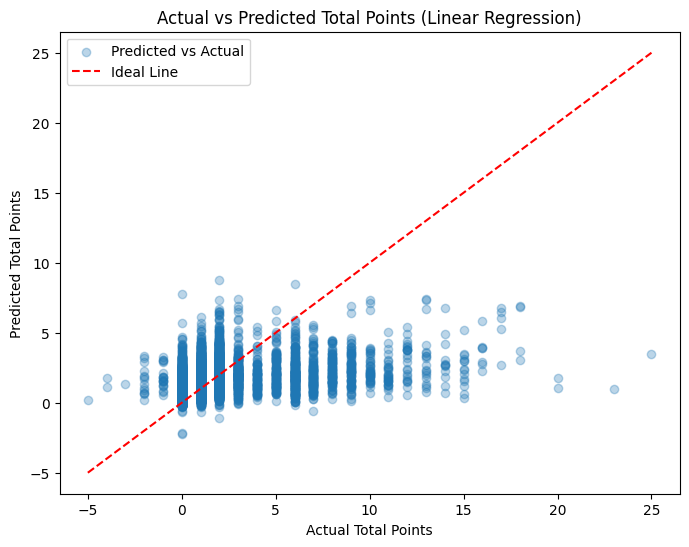

In [22]:
# Plot actual vs predicted with a diagonal line
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(y_test, y_pred_lr, alpha=0.3, label='Predicted vs Actual')

# Diagonal line
min_val = min(y_test.min(), y_pred_lr.min())  # Find the smallest value between actual and predicted
max_val = max(y_test.max(), y_pred_lr.max())  # Find the largest value between actual and predicted
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Line')

# Labels and title
plt.xlabel('Actual Total Points')
plt.ylabel('Predicted Total Points')
plt.title('Actual vs Predicted Total Points (Linear Regression)')
plt.legend()  # Add a legend
plt.show()

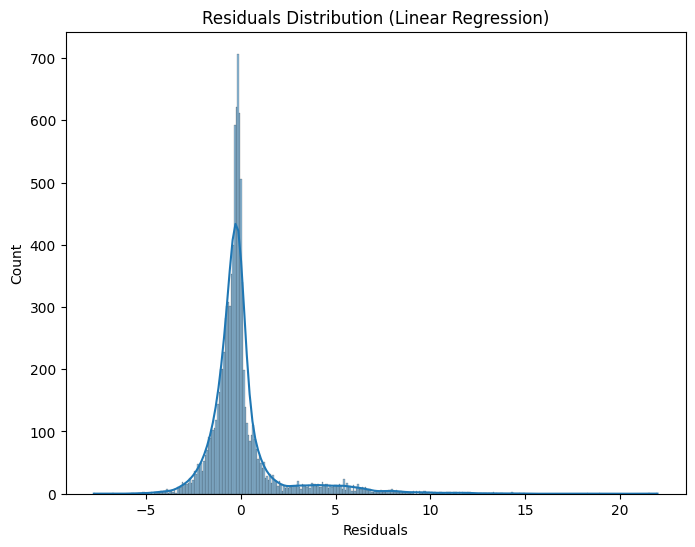

In [24]:

# Plot residuals
residuals = y_test - y_pred_lr
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution (Linear Regression)')
plt.xlabel('Residuals')
plt.show()


In [25]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [26]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)


In [27]:
# Calculate evaluation metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the results
print("Random Forest Performance on Test Set:")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R^2 Score: {r2_rf:.2f}")


Random Forest Performance on Test Set:
MAE: 1.19
RMSE: 2.13
R^2 Score: 0.18


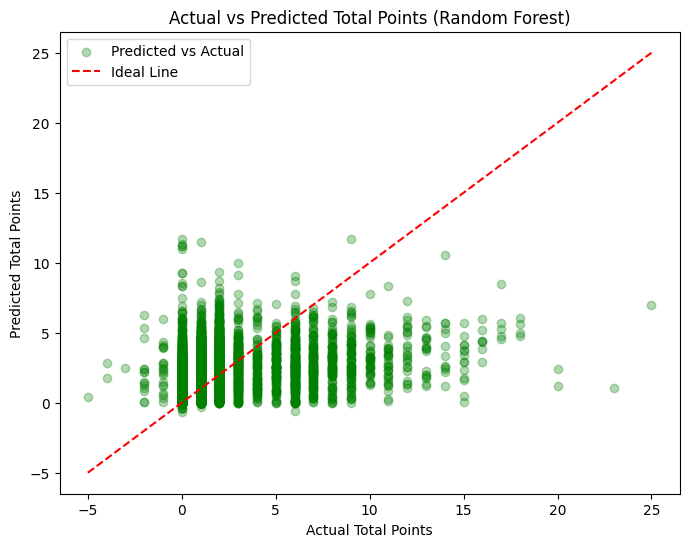

In [28]:
# Plot actual vs predicted with an ideal line
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='green', label='Predicted vs Actual')

# Diagonal ideal line
min_val = min(y_test.min(), y_pred_rf.min())  # Smallest value
max_val = max(y_test.max(), y_pred_rf.max())  # Largest value
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Line')

# Labels, title, and legend
plt.xlabel('Actual Total Points')
plt.ylabel('Predicted Total Points')
plt.title('Actual vs Predicted Total Points (Random Forest)')
plt.legend()  # Add legend
plt.show()


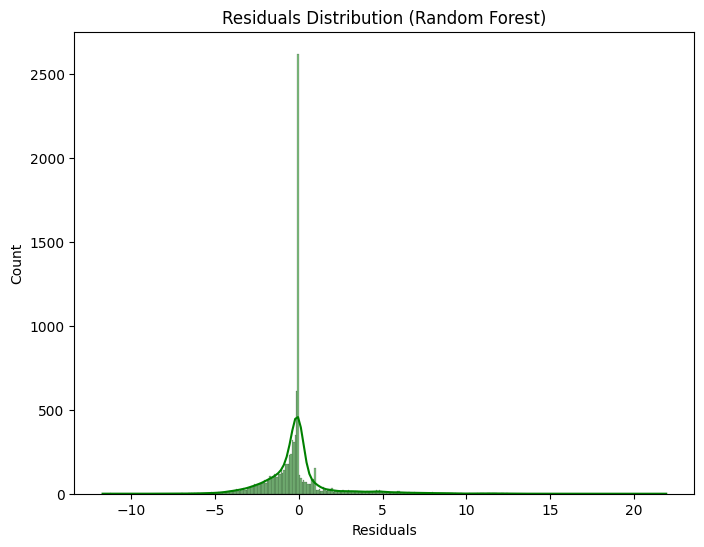

In [29]:
# Plot residuals
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(8,6))
sns.histplot(residuals_rf, kde=True, color='green')
plt.title('Residuals Distribution (Random Forest)')
plt.xlabel('Residuals')
plt.show()


In [31]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the model
xgb_model = XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Learning rate
    max_depth=4,       # Maximum depth of trees
    subsample=1,     # Fraction of samples used for training each tree
    # colsample_bytree=0.8,  # Fraction of features used for training each tree
    random_state=42    # Ensures reproducibility
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print the evaluation metrics
print("XGBoost Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R-squared (R²): {r2_xgb:.2f}")


XGBoost Model Performance:
Mean Absolute Error (MAE): 1.06
Root Mean Squared Error (RMSE): 2.02
R-squared (R²): 0.26


In [219]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0]
# }

# grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# print("Best Parameters:", grid_search.best_params_)
# best_model = grid_search.best_estimator_
# Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}

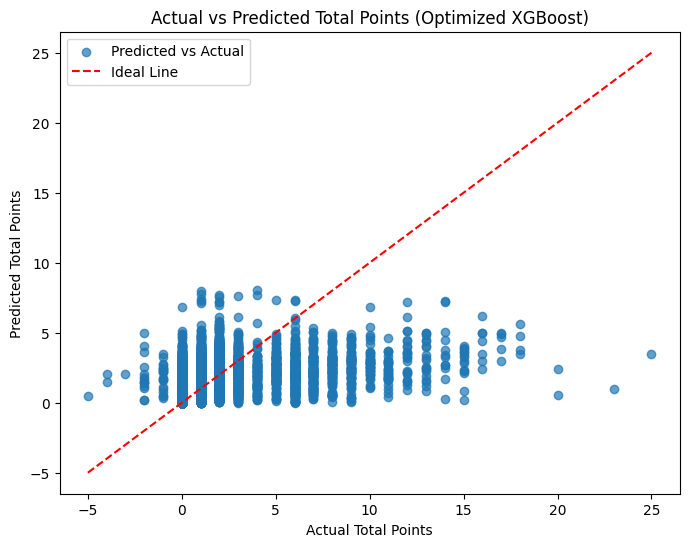

In [32]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Actual Total Points')
plt.ylabel('Predicted Total Points')
plt.title('Actual vs Predicted Total Points (Optimized XGBoost)')
plt.legend()
plt.show()

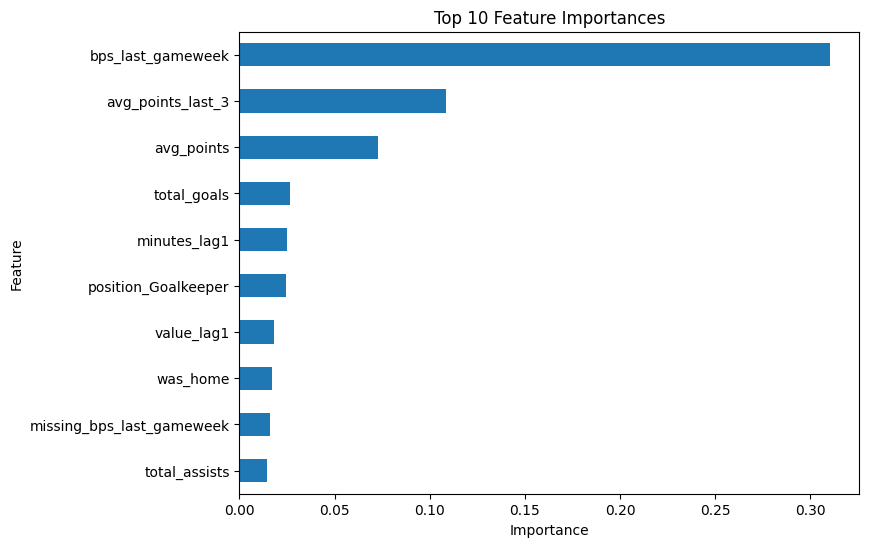

In [33]:
# Get feature importance
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 important features
feature_importance_df.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(8, 6))
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()


In [58]:
# Get feature importance from the model
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Print the top 20 features
top_20_features = feature_importance_df.head(20)
print("Top 20 Features by Importance:")
print(top_20_features)


Top 20 Features by Importance:
                       Feature  Importance
2            bps_last_gameweek    0.296580
104          avg_points_last_3    0.105082
105                 avg_points    0.075123
45                minutes_lag1    0.027934
106                total_goals    0.026601
50         weighted_goals_lag1    0.025656
39                  value_lag1    0.018564
3    missing_bps_last_gameweek    0.018080
6          position_Goalkeeper    0.017824
0                     was_home    0.017685
4            position_Defender    0.016636
83             creativity_lag2    0.015892
7          position_Midfielder    0.015281
107              total_assists    0.015060
54         weighted_goals_lag3    0.015027
99                 threat_lag1    0.014329
91              influence_lag3    0.012543
23           clean_sheets_lag2    0.012264
93              ict_index_lag1    0.012033
87              influence_lag1    0.011732


In [59]:
# Initialize an empty list to store metrics
position_metrics = []
# Group results by position
for position, group in results.groupby('Position'):
    # Actual and predicted points for the current position
    actual = group['Actual Points']
    predicted = group['Predicted Points']

    # Calculate metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    correlation = np.corrcoef(actual, predicted)[0, 1]

    # Append metrics to the list
    position_metrics.append({
        'Position': position,
        'MAE': mae,
        'RMSE': rmse,
        'Correlation': correlation
    })

# Convert the metrics list to a DataFrame
position_metrics_df = pd.DataFrame(position_metrics)

# Display metrics by position
print("Prediction Accuracy by Position:")
print(position_metrics_df)

Prediction Accuracy by Position:
     Position       MAE      RMSE  Correlation
0    Defender  1.090806  1.886978     0.452431
1     Forward  1.359050  2.425253     0.555488
2  Goalkeeper  0.812355  1.642626     0.606007
3  Midfielder  1.143859  2.094840     0.503496


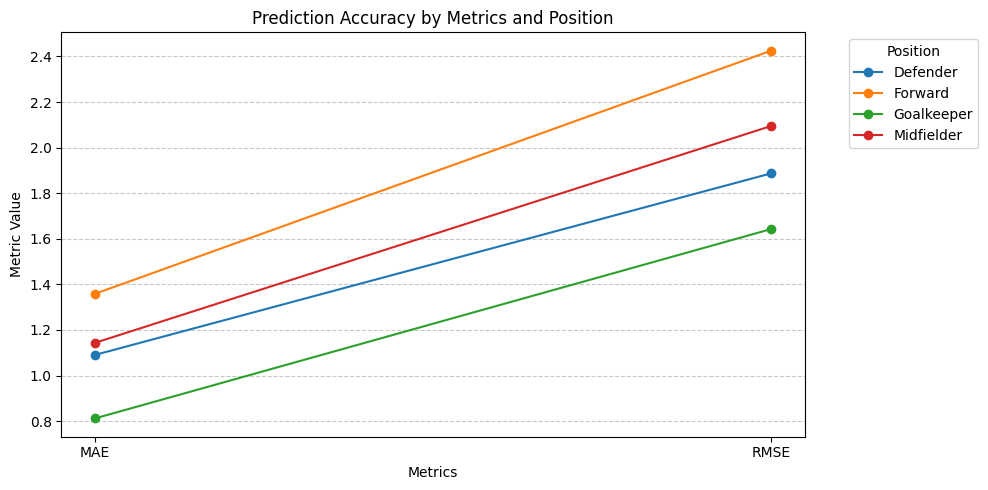

In [69]:
# Sort by Position for consistency (optional)
position_metrics_df = position_metrics_df.sort_values('Position')

# Metrics to plot
metrics = ['MAE', 'RMSE']

# Transpose the DataFrame for easier plotting
plot_data = position_metrics_df.set_index('Position')[metrics]

# Plotting
plt.figure(figsize=(10, 5))
for position in plot_data.index:
    plt.plot(metrics, plot_data.loc[position], marker='o', label=position)

# Add labels and legend
plt.xlabel('Metrics')
plt.ylabel('Metric Value')
plt.title('Prediction Accuracy by Metrics and Position')
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

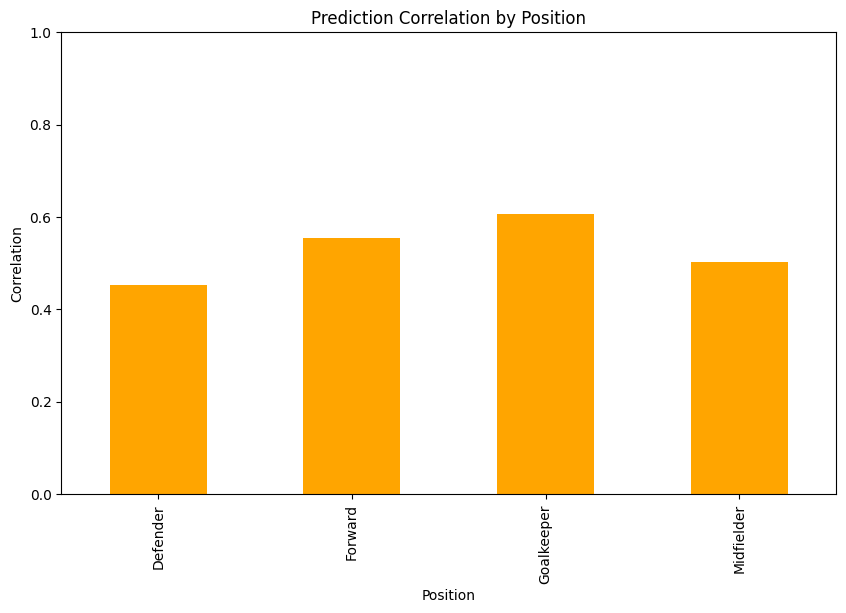

In [70]:
position_metrics_df.set_index('Position')['Correlation'].plot(kind='bar', figsize=(10, 6), color='orange')
plt.title("Prediction Correlation by Position")
plt.ylabel("Correlation")
plt.ylim(0, 1)  # Set y-axis limits for clarity
plt.show()


In [40]:
weights = y_train.apply(lambda x: 1 + (x / y_train.max()))
xgb_model.fit(X_train, y_train, sample_weight=weights)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [41]:
# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print the evaluation metrics
print("XGBoost Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R-squared (R²): {r2_xgb:.2f}")

XGBoost Model Performance:
Mean Absolute Error (MAE): 1.12
Root Mean Squared Error (RMSE): 2.03
R-squared (R²): 0.26


In [50]:
# Evaluate performance on top-scoring players
top_players = test_df[test_df['total_points'] > 10]
y_test_top = top_players['total_points']
X_test_top = top_players[features]

y_pred_top = xgb_model.predict(X_test_top)

mae_top = mean_absolute_error(y_test_top, y_pred_top)
print("MAE for Top Players:", mae_top)


MAE for Top Players: 9.995720811126645


In [43]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print("Cross-Validated MAE:", -cv_scores.mean())


Cross-Validated MAE: 1.0489954065196465


In [52]:
# Create a DataFrame with all predictions
results = pd.DataFrame({
    'Player Name': test_df['name'].values,
    'Position': test_df[['position_Defender', 'position_Forward',
                         'position_Goalkeeper', 'position_Midfielder']].idxmax(axis=1).values,
    'Gameweek': test_df['gameweek'].values,
    'Actual Points': y_test,
    'Predicted Points': y_pred_xgb
})
# Replace one-hot encoded position names
position_map = {
    'position_Defender': 'Defender',
    'position_Forward': 'Forward',
    'position_Goalkeeper': 'Goalkeeper',
    'position_Midfielder': 'Midfielder'
}
results['Position'] = results['Position'].map(position_map)

In [73]:
# Rank players by Actual and Predicted Points
results['Actual Rank'] = results.groupby('Position')['Actual Points'].rank(ascending=False)
results['Predicted Rank'] = results.groupby('Position')['Predicted Points'].rank(ascending=False)

# Combine rankings
results['Combined Rank'] = (results['Actual Rank'] + results['Predicted Rank']) / 2

# Get top players
top_n = 5
top_players = (
    results.groupby('Position', group_keys=False)
    .apply(lambda group: group.nsmallest(top_n, 'Combined Rank'))
)

# Display top players
print("Top Players with High Predicted and Actual Points:")
print(top_players[['Player Name', 'Position', 'Predicted Points']])

Top Players with High Predicted and Actual Points:
                             Player Name    Position  Predicted Points
110673            Trent Alexander-Arnold    Defender          4.371258
106075      Gabriel dos Santos Magalhães    Defender          3.828221
111235                    Joško Gvardiol    Defender          3.891926
106084      Gabriel dos Santos Magalhães    Defender          3.784008
112316                          Ola Aina    Defender          3.545120
111243                    Erling Haaland     Forward          5.853976
111245                    Erling Haaland     Forward          6.059523
106902                     Ollie Watkins     Forward          6.378584
106900                     Ollie Watkins     Forward          5.096202
114103  Matheus Santos Carneiro Da Cunha     Forward          4.971761
109540                   Jordan Pickford  Goalkeeper          3.859685
106246                    Aaron Ramsdale  Goalkeeper          4.230700
111726                    

<ipython-input-73-5beece248247>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.nsmallest(top_n, 'Combined Rank'))


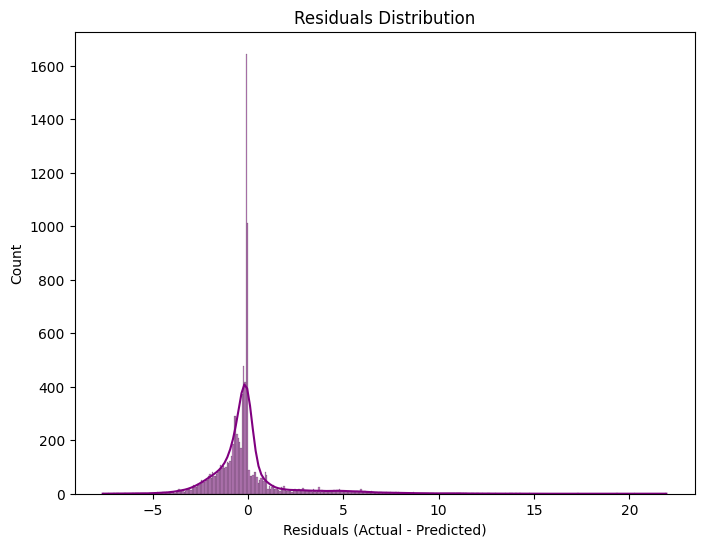

In [76]:
# Compute residuals
results['Residuals'] = results['Actual Points'] - results['Predicted Points']

# Plot residuals
plt.figure(figsize=(8, 6))
sns.histplot(results['Residuals'], kde=True, color='purple')
plt.title('Residuals Distribution')
plt.xlabel('Residuals (Actual - Predicted)')
plt.show()


In [75]:
# Residuals by position
residuals_by_position = results.groupby('Position')['Residuals'].mean().reset_index()
print("Average Residuals by Position:")
print(residuals_by_position)


Average Residuals by Position:
     Position  Residuals
0    Defender  -0.065319
1     Forward   0.089582
2  Goalkeeper  -0.016161
3  Midfielder  -0.065218
